# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [1]:
import torch
from torchvision import datasets, transforms

ModuleNotFoundError: No module named 'torchvision'

In [4]:
x = datasets.MNIST('data', download = True)
x[0]

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



15.9%

100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(<PIL.Image.Image image mode=L size=28x28>, 5)

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [6]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [7]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [8]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

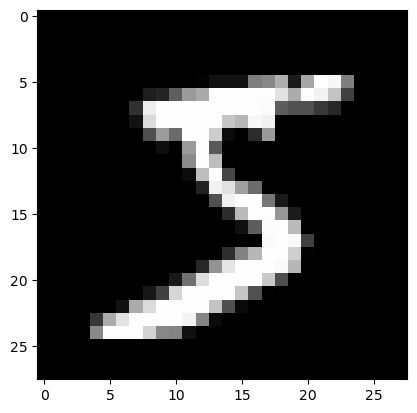

In [9]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

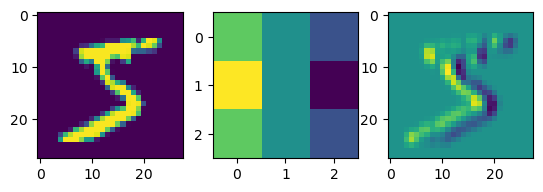

In [10]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [13]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_82679/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [14]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

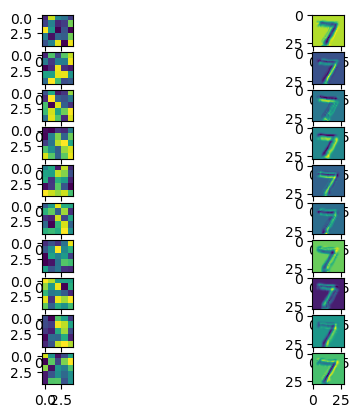

In [15]:
visualize()

# Predict Using Network

In [16]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [17]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_82679/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 4, 6, 5, 2])

# First Test and Train

In [18]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [19]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_82679/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 5%



In [20]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [21]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_82679/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.352986
Train loss: 1.825249
Train loss: 1.147921
Train loss: 0.837992
Train loss: 0.612385
Train loss: 0.689186
Train loss: 0.524184
Train loss: 0.632756
Train loss: 0.381104
Train loss: 0.451344


# Train Network

In [22]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_82679/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.322989
Train loss: 2.051409
Train loss: 1.030995
Train loss: 0.892037
Train loss: 0.676602
Train loss: 0.696181
Train loss: 0.566705
Train loss: 0.628674
Train loss: 0.456906
Train loss: 0.532637
Test accuracy: 94%

Train loss: 0.282810
Train loss: 0.322777
Train loss: 0.351278
Train loss: 0.422496
Train loss: 0.400076
Train loss: 0.420013
Train loss: 0.307214
Train loss: 0.507712
Train loss: 0.398367
Train loss: 0.451056
Test accuracy: 96%

Train loss: 0.345969
Train loss: 0.439955
Train loss: 0.225032
Train loss: 0.502510
Train loss: 0.141682
Train loss: 0.243182
Train loss: 0.220158
Train loss: 0.385915
Train loss: 0.335687
Train loss: 0.383433
Test accuracy: 97%

Train loss: 0.226939
Train loss: 0.263712
Train loss: 0.301075
Train loss: 0.295922
Train loss: 0.146064
Train loss: 0.312559
Train loss: 0.285867
Train loss: 0.465996
Train loss: 0.280609
Train loss: 0.393093
Test accuracy: 98%

Train loss: 0.125489
Train loss: 0.307727
Train loss: 0.155767
Train loss: 0.267

# Inspect Network

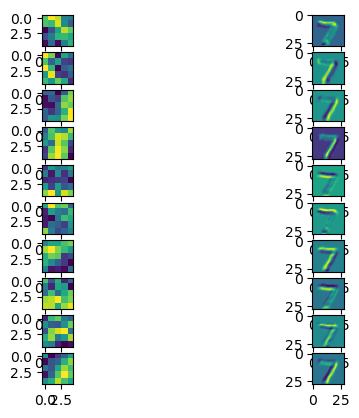

In [23]:
visualize()

In [24]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [25]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_82679/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [ ]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [ ]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

In [ ]:
visualize()

## New Code:

### 60,000 images:

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_82679/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.314894
Train loss: 2.128808
Train loss: 1.217509
Train loss: 0.882137
Train loss: 0.783057
Train loss: 0.651010
Train loss: 0.371055
Train loss: 0.605127
Train loss: 0.496427
Train loss: 0.615449
Test accuracy: 94%

Train loss: 0.545065
Train loss: 0.356875
Train loss: 0.309155
Train loss: 0.425933
Train loss: 0.313975
Train loss: 0.315361
Train loss: 0.290342
Train loss: 0.514506
Train loss: 0.382620
Train loss: 0.333846
Test accuracy: 96%

Train loss: 0.346176
Train loss: 0.402578
Train loss: 0.169187
Train loss: 0.339141
Train loss: 0.202444
Train loss: 0.152947
Train loss: 0.251621
Train loss: 0.513691
Train loss: 0.454556
Train loss: 0.463134
Test accuracy: 97%

Train loss: 0.196794
Train loss: 0.241063
Train loss: 0.179281
Train loss: 0.382991
Train loss: 0.312609
Train loss: 0.162998
Train loss: 0.166782
Train loss: 0.432805
Train loss: 0.280100
Train loss: 0.263743
Test accuracy: 98%

Train loss: 0.128076
Train loss: 0.181131
Train loss: 0.367846
Train loss: 0.336

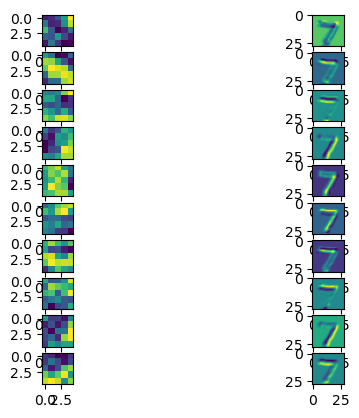

In [28]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()

### 30,000 images:

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_82679/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.358792
Train loss: 1.944900
Train loss: 1.171196
Train loss: 0.784446
Train loss: 0.712474
Test accuracy: 90%

Train loss: 0.647089
Train loss: 0.394166
Train loss: 0.467833
Train loss: 0.531420
Train loss: 0.590574
Test accuracy: 94%

Train loss: 0.454490
Train loss: 0.412701
Train loss: 0.427556
Train loss: 0.719908
Train loss: 0.355222
Test accuracy: 96%

Train loss: 0.367970
Train loss: 0.303313
Train loss: 0.299304
Train loss: 0.318842
Train loss: 0.415339
Test accuracy: 96%

Train loss: 0.289036
Train loss: 0.181631
Train loss: 0.276468
Train loss: 0.386542
Train loss: 0.201617
Test accuracy: 97%



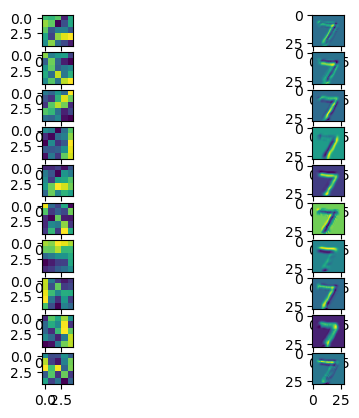

In [29]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()

### 6,000 images:

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_82679/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.307063
Test accuracy: 31%

Train loss: 2.213949
Test accuracy: 67%

Train loss: 1.733354
Test accuracy: 83%

Train loss: 1.161315
Test accuracy: 87%

Train loss: 1.020828
Test accuracy: 89%



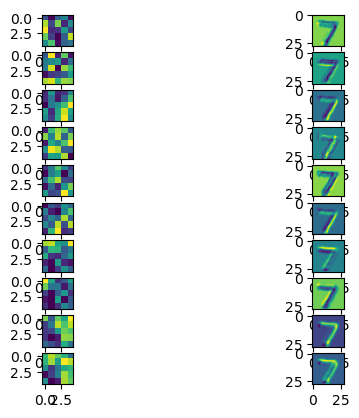

In [30]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()

### 3,000 images:

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_82679/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.337692
Test accuracy: 20%

Train loss: 2.262171
Test accuracy: 59%

Train loss: 2.190830
Test accuracy: 66%

Train loss: 1.773330
Test accuracy: 77%

Train loss: 1.534094
Test accuracy: 83%



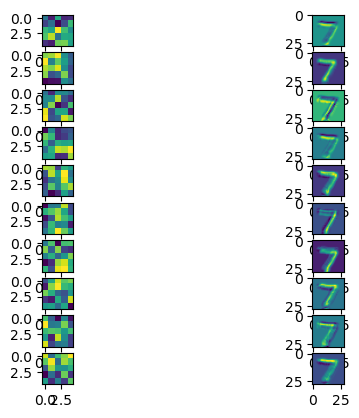

In [31]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()

### 600 images:

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_82679/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.315953
Test accuracy: 17%

Train loss: 2.286668
Test accuracy: 23%

Train loss: 2.273612
Test accuracy: 33%

Train loss: 2.256262
Test accuracy: 36%

Train loss: 2.211417
Test accuracy: 42%



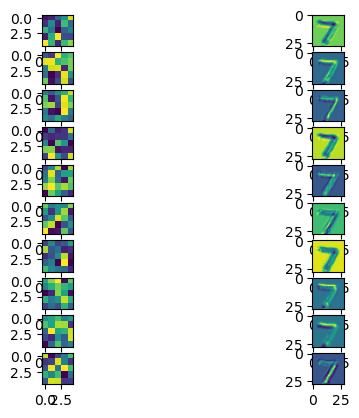

In [32]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()

## Question 1.1
For 60,000 images, the accuracy is 94% after 1 epoch and 98% after 5 epochs. For 30,000 images, it starts at 90% and goes to 97% after 5 epochs. At 6,000 images, these accuracy measurements decrease to 31% and 89%, respectively. At 3,000, the accuracy readings go from 20% to 83% with additional epochs. Lastly, the accuracy for 600 images starts at 17% and increases to 42% after 5 epochs. These results make sense, as more images provide more data for the training.   

## Question 1.2
When given 60,000 images to train with, the weights look well organized and appear to have high accuracy. As the number of images decreases down to only 600, the weights look more disorganized and less accurate in terms of image analysis predictions. 